In [3]:
# working environment
!nvidia-smi

Sat Apr 15 23:54:59 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         On | 00000000:65:00.0 Off |                  N/A |
|  0%   43C    P8               39W / 390W|    226MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Import the required libraries

In [37]:
import tensorflow as tf
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Download the datasets

In [2]:
(train_ds, test_ds), ds_info = tfds.load(
    "cats_vs_dogs",
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
    shuffle_files=True
)

2023-04-16 02:25:42.407659: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22037 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


In [3]:
class_names = ds_info.features['label'].names
class_names

['cat', 'dog']

In [8]:
len(train_ds), len(test_ds), len(train_ds) + len(test_ds)

(18610, 4652, 23262)

DOG


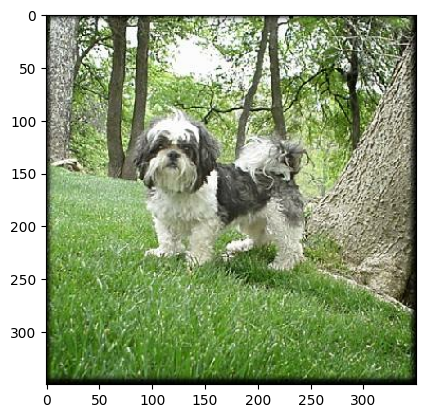

In [48]:
for x in train_ds:
    print(class_names[x[1]].upper())
    plt.figure()
    plt.imshow(x[0])
    break

# Prepare the datasets

In [15]:
def func(image, label):
    return tf.image.resize(image, (224, 224)), label

In [16]:
train = train_ds.map(func).batch(32).prefetch(tf.data.AUTOTUNE).cache()
test = train_ds.map(func).batch(32).prefetch(tf.data.AUTOTUNE)

# Build the model

In [17]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3)) 
x = tf.keras.layers.BatchNormalization()(inputs)
x = tf.keras.layers.Conv2D(256, 3, activation='relu', kernel_initializer="he_uniform")(x)
x = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='valid', kernel_initializer="he_uniform")(x)
x = tf.keras.layers.MaxPooling2D(2)(x)
x = tf.keras.layers.Conv2D(256, 3, activation='relu')(x)
x = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='valid', kernel_initializer="he_uniform")(x)
x = tf.keras.layers.MaxPooling2D(2)(x)
x = tf.keras.layers.Conv2D(256, 3, activation='relu')(x)
x = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='valid', kernel_initializer="he_uniform")(x)
x = tf.keras.layers.AveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 batch_normalization_2 (Batc  (None, 224, 224, 3)      12        
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 222, 222, 256)     7168      
                                                                 
 conv2d_7 (Conv2D)           (None, 220, 220, 256)     590080    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 110, 110, 256)    0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 108, 108, 256)     5900

# Train the model

In [18]:
history = model.fit(train, epochs=100, validation_data=test, validation_steps=len(test) * 0.25, callbacks=[tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=6)])

Epoch 1/100


2023-04-16 03:19:14.041071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [7]
	 [[{{node Placeholder/_3}}]]
2023-04-16 03:19:14.042044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7]
	 [[{{node Placeholder/_0}}]]


190/582 [========>.....................] - ETA: 1:37 - loss: 1.0359 - accuracy: 0.5921

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


221/582 [==========>...................] - ETA: 1:30 - loss: 0.9804 - accuracy: 0.5967

234/582 [===========>..................] - ETA: 1:27 - loss: 0.9630 - accuracy: 0.5972

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


307/582 [==============>...............] - ETA: 1:12 - loss: 0.8853 - accuracy: 0.6059

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.7742 - accuracy: 0.6297

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


527/582 [==========================>...] - ETA: 14s - loss: 0.7689 - accuracy: 0.6311

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


537/582 [==========================>...] - ETA: 11s - loss: 0.7651 - accuracy: 0.6327

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


564/582 [============================>.] - ETA: 4s - loss: 0.7562 - accuracy: 0.6353

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


570/582 [============================>.] - ETA: 3s - loss: 0.7549 - accuracy: 0.6350

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7517 - accuracy: 0.6359

2023-04-16 03:21:45.240800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [7]
	 [[{{node Placeholder/_3}}]]
2023-04-16 03:21:45.241187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [7]
	 [[{{node Placeholder/_3}}]]


582/582 [==============================] - 167s 284ms/step - loss: 0.7517 - accuracy: 0.6359 - val_loss: 0.5913 - val_accuracy: 0.6860
Epoch 2/100
582/582 [==============================] - 161s 277ms/step - loss: 0.5471 - accuracy: 0.7151 - val_loss: 0.5196 - val_accuracy: 0.7410
Epoch 3/100
582/582 [==============================] - 161s 277ms/step - loss: 0.4771 - accuracy: 0.7696 - val_loss: 0.4657 - val_accuracy: 0.7793
Epoch 4/100
582/582 [==============================] - 161s 277ms/step - loss: 0.3891 - accuracy: 0.8246 - val_loss: 0.5122 - val_accuracy: 0.7697
Epoch 5/100
582/582 [==============================] - 161s 277ms/step - loss: 0.2826 - accuracy: 0.8852 - val_loss: 0.4943 - val_accuracy: 0.8033
Epoch 6/100
582/582 [==============================] - 161s 277ms/step - loss: 0.1529 - accuracy: 0.9466 - val_loss: 0.4021 - val_accuracy: 0.8570
Epoch 7/100
582/582 [==============================] - 161s 277ms/step - loss: 0.0905 - accuracy: 0.9707 - val_loss: 0.4135 - val_

# Save the model

In [19]:
model.save("saved_model.h5")

In [68]:
model.save_weights("saved_weights.h5")

# Load the model

In [188]:
# model.load_weights("saved_weights.h5")

In [12]:
loaded_model = tf.keras.models.load_model("saved_model.h5")

# Evaluate the model

    

<Axes: >

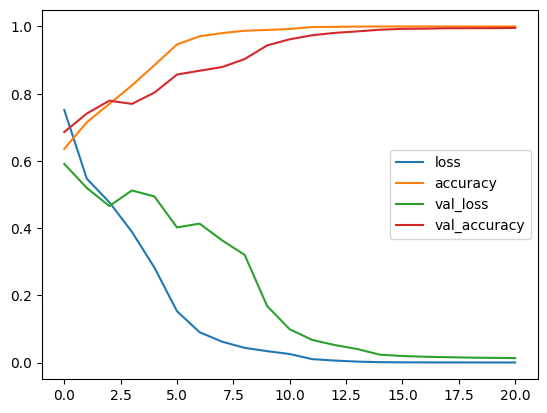

In [20]:
pd.DataFrame(history.history).plot()

In [22]:
evaluate = model.evaluate(test)
print("Testing accuracy:", evaluate[1])

194/582 [=========>....................] - ETA: 42s - loss: 0.0116 - accuracy: 0.9966

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 38s - loss: 0.0114 - accuracy: 0.9967

238/582 [===========>..................] - ETA: 37s - loss: 0.0116 - accuracy: 0.9966

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


305/582 [==============>...............] - ETA: 30s - loss: 0.0110 - accuracy: 0.9970

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 7s - loss: 0.0101 - accuracy: 0.9972

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 5s - loss: 0.0101 - accuracy: 0.9971

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 4s - loss: 0.0101 - accuracy: 0.9971

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 1s - loss: 0.0101 - accuracy: 0.9971

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 0s - loss: 0.0101 - accuracy: 0.9971

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 64s 109ms/step - loss: 0.0102 - accuracy: 0.9970
Testing accuracy: 0.9969908595085144


# Plot the confusion matrix

In [24]:
def conf_matrix(y_test=None, y_pred=None, class_names=None):
    
    cm = confusion_matrix(y_test, y_pred)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    a = ax.matshow(cm, cmap=plt.cm.Greens)  
    
    fig.colorbar(a)  
    
    ax.set(title="Confusion Matrix",
             xlabel="Predicted label",
             ylabel="Actual label",
             xticks=np.arange(len(class_names)), 
             yticks=np.arange(len(class_names)), 
             xticklabels=class_names,  
             yticklabels=class_names)
    
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    
    plt.xticks(rotation=60, fontsize=20)
    plt.yticks(fontsize=20)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]}",
                  horizontalalignment="center", color="black" if cm[i, j] < (cm.max() + cm.min()) / 2 else "white",
                  fontsize=20)

In [34]:
y_pred = []
y_truth = []

for x, y in test:
    y_pred.extend(model.predict([x], verbose=0).round())
    y_truth.extend(y.numpy())

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


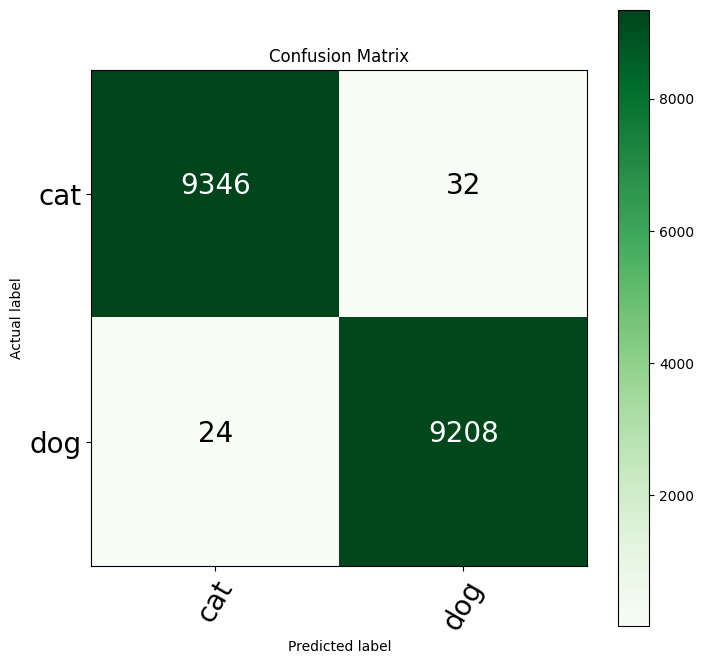

In [38]:
conf_matrix(y_test=y_truth, y_pred=y_pred, class_names=class_names)